**Lab 4: FIR filters and envelopes**

The goal of this lab is to learn how to implement FIR filters in Python, and how we can use them to improve our synthesis.

In [17]:
import os
import numpy as np
import librosa
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt
import soundfile as sf

from util import load_audio, plot_signals, plot_spectrogram, plot_mean_spectrogram, save_audio

**1. Overview of Filtering**

For this lab, we will define an FIR filter as a discrete-time system that converts an input signal $x[n]$ into an output signal $y[n]$ by means of the weighted summation:

$$
y[n] = \sum_{k=0}^M b_kx[n-k]
$$

The function *np.convolve()* is a generic function with which to implement FIR filters. The following code implements a three-point averaging system:

In [2]:
fs = 1
x = [np.floor(x/10) for x in range(50)]
b = np.array([1.0/3, 1.0/3, 1.0/3])
y = np.convolve(b, x)

plot_signals([x, y], fs, name=['input x[n]', 'output y[n]'], mode='lines+markers')

1.1 Explain the filtering action of the 5-point averager by comparing the plot of the input $x[n]$ and the output $y[n]$. This filter might be called a “smoothing” filter. Note how the transitions from one level to another have been “smoothed.”

The 5-point averager, is used to smooth or average a signal. It operates by averaging the current sample and four previous samples from the input signal to create a smoother output. This filtering action reduces the impact of high-frequency noise and sharp transitions in the input. We can see this from the example above by notiching how the transitions last longer and have less of an angle of attack. It's an overall smoother graphic than the blue one.

*1.2* Define a function `averaging_filter(x, N)` which implements the N-points averaging filter using the `np.convolve` function.

In [3]:
import numpy as np

def averaging_filter(x, N):
    """
    Applies a N-point averaging filter to the input signal x

    Parameters
    ----------
    x : np.array
        The input signal in the form of a numpy array
    N : int
        The number of points used in N-point averaging filter

    Returns
    -------
    y : np.array
        The output of the filter
    """
    b = np.ones(N) / N  # filtering coeffs
    y = np.convolve(b, x, mode='valid') # apply filter
    return y

# example
input_signal = np.array([1, 2, 3, 4, 10, 6, 7, 8, 9])
N = 3
filtered_signal = averaging_filter(input_signal, N)
print("Input Signal:", input_signal)
print("Filtered Signal:", filtered_signal)



Input Signal: [ 1  2  3  4 10  6  7  8  9]
Filtered Signal: [2.         3.         5.66666667 6.66666667 7.66666667 7.
 8.        ]


1.3 Run the example above using the `averaging_filter` instead. Change the number N to different values and explain what happen.

In [4]:
a = averaging_filter(x, 5)
b = averaging_filter(x, 6)
c = averaging_filter(x, 7)
plot_signals([a, b, c], fs, name=['N = 5', 'N = 6', 'N = 7'], mode='lines+markers')

- The larger N is, the smoother it gets the new signal.

In [5]:
n_samples = 500 
t = np.linspace(0, 10, n_samples)  
frequency = 1.0  
amplitude = 1.0 
noise_stddev = 0.2  

# Generate a noisy sine wave signal
x = amplitude * np.sin(2 * np.pi * frequency * t) + noise_stddev * np.random.randn(n_samples)
a = averaging_filter(x, 5)
b = averaging_filter(x, 6)
c = averaging_filter(x, 7)
plot_signals([x, a, b, c], fs, name=['normal signal','N = 5', 'N = 6', 'N = 7'], mode='lines+markers')


1.4 How would you classify this filter, as a low-pass o high-pass filter?

It smooths the signal by averaging a range of samples, which effectively reduces the impact of high-frequency noise or rapid changes in the signal. This behavior makes it a low-pass filter, as it passes the lower-frequency components and attenuates the higher-frequency components, resulting in a smoother signal.







---

**2. Envelope detector**

Now we'll implement an envelope detector by concatenating two systems: a full-wave rectifier (absolute value) and the N-point averaging filter.

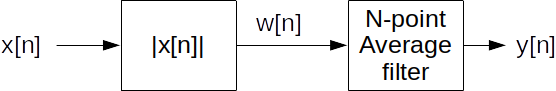

2.1 Define a function `envelope(x, N)` which applies an N-point averaging filter to the full-wave rectified signal and returns the output $y[n]$.

**Note 1**: to calculate the full-wave rectified signal check the `np.abs()` function.

**Note 2**: The output should have the same length as the input signal. Use 'same' mode (see [np.convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) documentation).

In [20]:
def envelope(x, N):
    """
    Extracts the envelope of the input signal x by concatenating a full-wave rectifier and an N-point averaging filter.

    Parameters
    ----------
    x : np.array
        The input signal in the form of a numpy array
    N : int
        The number of points used in N-point averaging filter

    Returns
    -------
    y : np.array
        The output of the system, i.e., the envelope of the signal x.
    """
    if N < 1:
      raise ValueError("N must be at least 1")

    # Step 1: Full-wave rectifier (absolute value)
    # Step 2: Apply N-point averaging filter to the rectified signal
    rectified_signal = np.abs(x)
    filter_coeffs = np.ones(N) / N
    envelope_signal = np.convolve(rectified_signal, filter_coeffs, mode='same')

    return envelope_signal

# This function first calculates the full-wave rectified signal by taking the absolute value of the input signal x. 
# Then, it applies an N-point averaging filter to the rectified signal, resulting in the envelope of the input signal. The output has the same length as the input signal, as specified in the docstring.

2.2 Load your reference signal and calculate its envelope using the function you designed. Plot the reference signal and envelope in the same figure.

In [49]:
filepath = "./audio/Guitar_A440.wav"
ref, fs = load_audio(filepath)

import numpy as np
import matplotlib.pyplot as plt

audio_data, fs = load_audio(filepath)
frequency = 235.8
A = 0.8  #Amplitude obtained from the plot of the audio signal
fs = 44100   #sampling frequency typically used for audio signals
phi= np.pi/2
period = 1 / frequency
t_start = 0.7
t_end = t_start + 7 * period 
#t = np.arange(t_start,4, 1.0/fs)
t = np.arange(t_start, audio_data.shape[0]/fs, 1.0 / fs)

envelope_signal = envelope(audio_data, 80) 


plot_signals([envelope_signal,audio_data], fs, t_start,t_end, name=['Enveloped signal', 'Original'])

2.3 Change the number N to get a good result. What happens when you change the number N?

When you change the number N to a higher value, the result displayed it's smoother.

2.4 Explain with your own words why this system achieves extracting the envelope. It might be useful to plot together the signals $x[n]$, $w[n]$ and $y[n]$.

The envelope extraction system works by first rectifying the input signal, which means taking the absolute value of the signal to ensure all values are positive. This step effectively captures the amplitude variations of the signal. Then, an N-point averaging filter is applied to the rectified signal. This filter smooths out the rapid fluctuations, resulting in a smoother curve that follows the general shape of the original signal's amplitude variations. By plotting the original signal, the rectified signal, and the envelope, we can visually see how the envelope captures the overall amplitude trend of the signal while ignoring the high-frequency content.

In [61]:
# Rectify the signal (w[n]) - Absolute value of the original signal
w_signal = np.abs(audio_data)

# Use the previously computed envelope_signal as y[n]
y_signal = envelope_signal

# Plot all three signals: x[n], w[n], y[n]
plot_signals(
    [audio_data, w_signal, y_signal],
    fs,
    t_start,
    t_end,
    name=["Original Signal x[n]", "Rectified Signal w[n]", "Enveloped Signal y[n]"]
)


2.5 Now let's apply this envelope to the synthesized signal. Copy the code from Lab3 Ex. 2.1 and generate the synthesized signal. Then multiply the synthesized signal by the envelope. Note that both signal and envelope should have the same length. You can define a time vector of the same length of the envelope to create the signal:

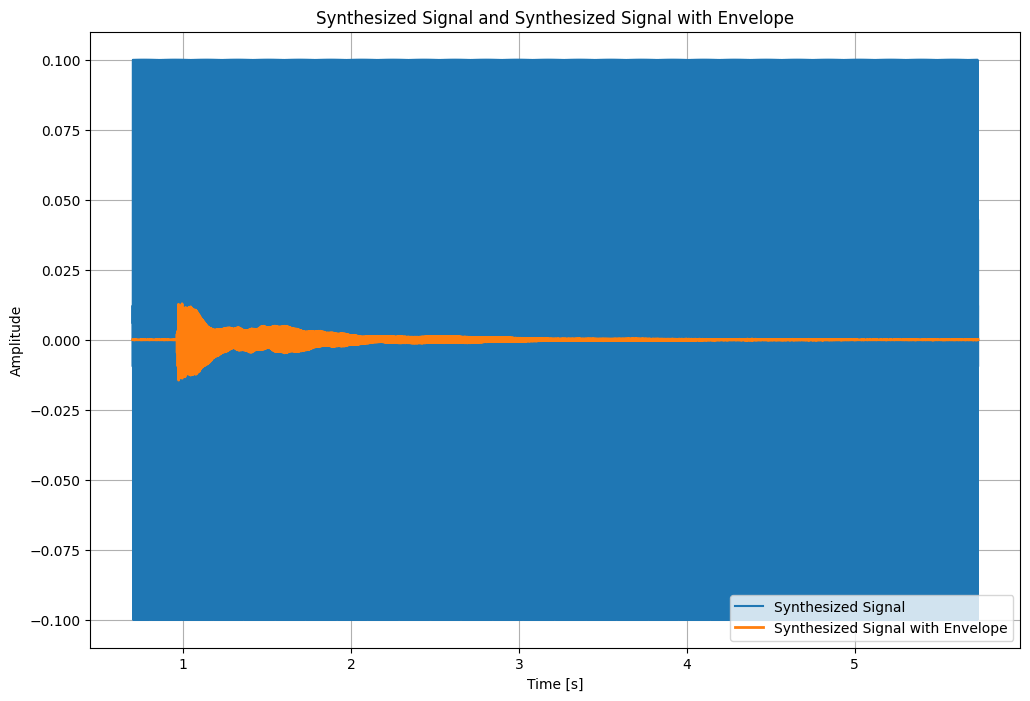

In [63]:
# Ensure t matches the time range of audio_data
t = np.arange(t_start, t_start + len(envelope_signal) / fs, 1.0 / fs)

# Function to synthesize signal
def synthesize(f0, phi, Ak, t):
    y = 0
    for k in range(1, len(Ak) + 1):
        y += Ak[k - 1] * np.cos(2 * np.pi * k * f0 * t + k * phi - (k - 1) * np.pi / 2)
    return y

# Synthesize the signal
f_0 = 235.8
phi = -np.pi / 2
weights = [0.834, 1, 0.865, 0.224, 0.034, 0.119, 0.054, 0.016, 0.028]

# Generate the synthesized signal
y_1 = synthesize(f_0, phi, weights, t)

# Normalize the synthesized signal
y_1 = 0.1 * y_1 / np.amax(y_1)

# Resample envelope_signal if lengths differ
if len(y_1) != len(envelope_signal):
    min_len = min(len(y_1), len(envelope_signal))
    y_1 = y_1[:min_len]
    envelope_signal = envelope_signal[:min_len]

# Apply the envelope to the synthesized signal
synth_signal_with_envelope = y_1 * envelope_signal

# Plot the signals
plt.figure(figsize=(12, 8))
plt.plot(t[:len(y_1)], y_1, label='Synthesized Signal')
plt.plot(t[:len(synth_signal_with_envelope)], synth_signal_with_envelope, label='Synthesized Signal with Envelope', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Synthesized Signal and Synthesized Signal with Envelope')
plt.legend()
plt.grid(True)
plt.show()


2.6. Compare the spectrograms of the reference signal and the synthesized signal. What are the main differences?

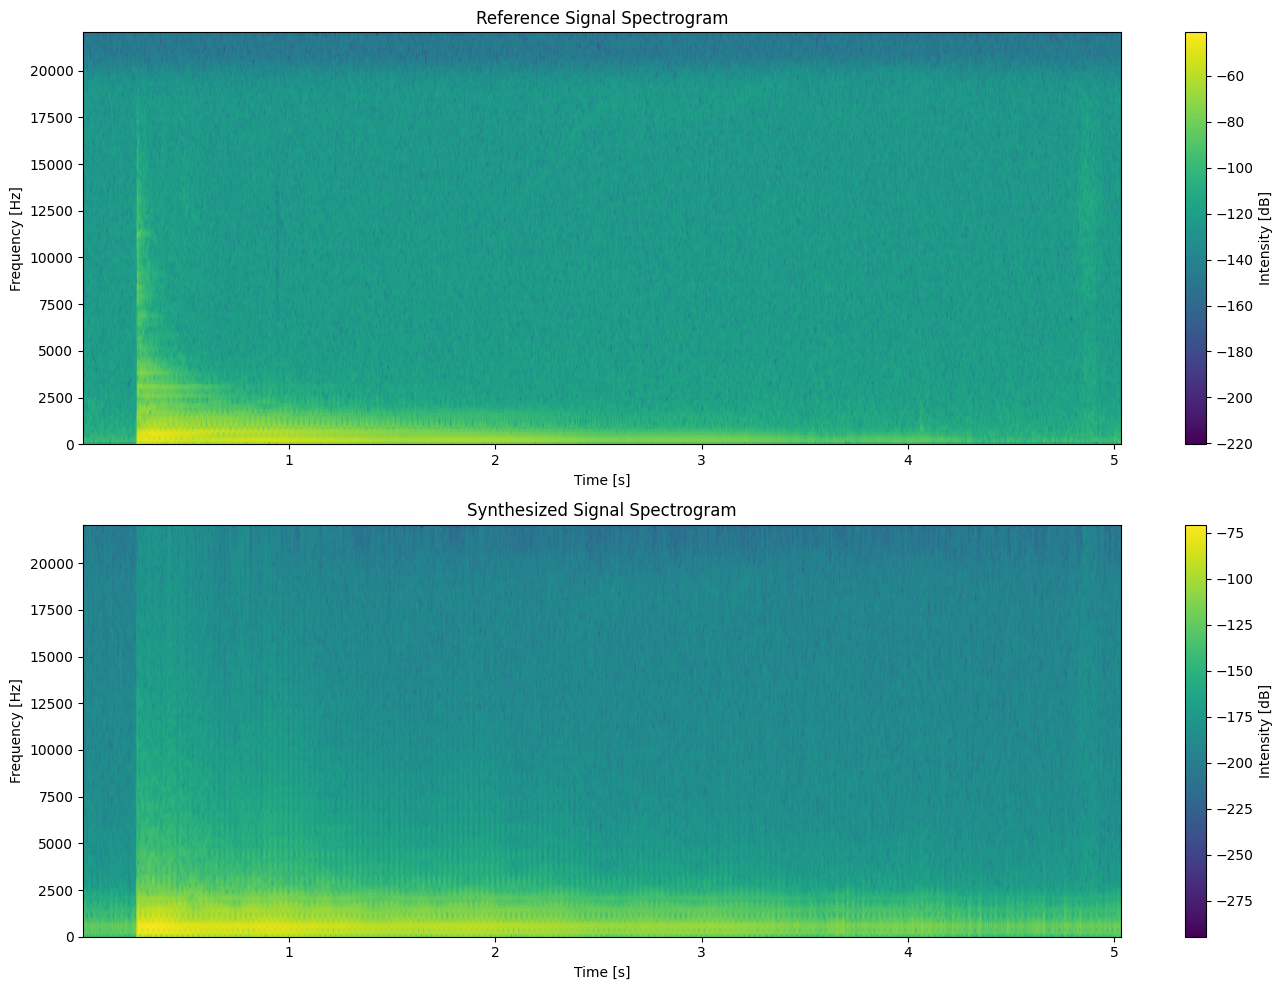

In [56]:
window_length = 256 

frequencies_ref, times_ref, Sxx_ref = signal.spectrogram(ref, fs, nperseg=window_length)
frequencies_synth, times_synth, Sxx_synth = signal.spectrogram(synth_signal_with_envelope, fs, nperseg=window_length)

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.pcolormesh(times_ref, frequencies_ref, 10 * np.log10(Sxx_ref), shading='gouraud')
plt.title('Reference Signal Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Intensity [dB]')
plt.subplot(2, 1, 2)
plt.pcolormesh(times_synth, frequencies_synth, 10 * np.log10(Sxx_synth), shading='gouraud')
plt.title('Synthesized Signal Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Intensity [dB]')

plt.tight_layout()
plt.show()

The main difference is that the synthesized signal is lacking higher frequencies, which can also be observed from the spectrum. Additionally, there is no decay over time. However, aside from this and the length of the audio, the rest is quite similar.

2.7 Listen to the synthesized signal and compare it to the reference.



In [64]:
from IPython.display import Audio
synthesize_envelope= y_1*envelope(y_1, 4)
Audio(synthesize_envelope, rate=fs)



In [ ]:
Audio(ref, rate=fs) 

-   Comparing the results of both signals we can capture a very noticeable robotic sound in the synthesized singal probably due to the fact of reducing the high frequencies with the envelope.